# **Topic Modeling (LDA) with COVID19 Tweets**

This notebook delves into the world of COVID-19 Twitter discourse, aiming to uncover the prevalent topics of discussion during the pandemic. We will utilize Latent Dirichlet Allocation (LDA), a powerful topic modeling technique, to automatically identify recurring themes and clusters of related keywords within the tweets. By analyzing these topics, we hope to gain insights into public sentiment, concerns, and information dissemination surrounding COVID-19 on Twitter. The analysis will involve data cleaning, preprocessing, LDA model implementation, and visualization of the extracted topics.

## 00. Libraries and Packages

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import plotly.express as px

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...


True

## 01. Data Load

In [4]:
df = pd.read_csv('covid19_tweets.csv', delimiter = ',')

In [5]:
print(f'Tamaño del dataset: {df.shape}')
df.head()

Tamaño del dataset: (179108, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


## 02. Preprocessing

### Data Cleaning

In [6]:
# Text to lowercase
df['text_clean'] = df['text'].str.lower()

In [7]:
pattern = r'[^a-zA-Z0-9\s]'
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(pattern, '', x))

### Tokenization

In [8]:
# Tokenize the 'text' column
df['tokenized_text'] = df['text_clean'].apply(lambda x: word_tokenize(x))

### Lemmatization

In [9]:
# Define a function to lemmatize words
lemmatizer = WordNetLemmatizer()
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply the lemmatize_words function to the 'filtered_text' column
df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_words)

### Remove Stopwords

Words such as 'covid19' and 'coronavirus' are removed because they are too general and ubiquitous in the corpus, and therefore won't provide any distinctive value in differentiating between the specific topics. These words are often referred to as "core terms" or "background terms" and are typically removed in topic modeling to allow for more nuanced and specific topics to emerge.

In [10]:
# Define a function to remove stopwords
stop_words = set(stopwords.words('english'))
new_stopwords = ['wa','ha','u','day','get','amp','covid19','coronavirus']
stop_words.update(new_stopwords)

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the remove_stopwords function to the 'tokenized_text' column
df['filtered_text'] = df['lemmatized_text'].apply(remove_stopwords)

In [11]:
df.sample(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,text_clean,tokenized_text,lemmatized_text,filtered_text
172907,Saksi™,"Colombo, SriLanka",Media Diplomat | Journalist | TV Host | Broadc...,2010-07-15 13:26:14,2495,638,3727,False,2020-08-30 02:44:29,The Department of #Muslim Religious and Cultur...,"['Muslim', 'COVID19']",Twitter for iPhone,False,the department of muslim religious and cultura...,"[the, department, of, muslim, religious, and, ...","[the, department, of, muslim, religious, and, ...","[department, muslim, religious, cultural, affa..."
44071,"@apfns: Gamer,Talker,Musician","Dalton,GA the United States","American Singer/Songwriter,Christian,Independe...",2014-07-19 09:33:30,781,1744,19860,False,2020-07-30 20:10:11,Im saying No Thanks to plasma for traces of an...,['COVID19'],Twitter for Android,False,im saying no thanks to plasma for traces of an...,"[im, saying, no, thanks, to, plasma, for, trac...","[im, saying, no, thanks, to, plasma, for, trac...","[im, saying, thanks, plasma, trace, antibody, ..."
103996,Julian Kendall,Abu Dhabi,'Every passing minute is another chance to tur...,2009-03-30 03:21:06,829,4996,45760,False,2020-08-11 09:45:41,@hula_grl In our neck of the woods Female Lead...,['COVID19'],Twitter Web App,False,hulagrl in our neck of the woods female leader...,"[hulagrl, in, our, neck, of, the, woods, femal...","[hulagrl, in, our, neck, of, the, wood, female...","[hulagrl, neck, wood, female, leadership, exce..."
103140,Shad from DC,WDC,"This haiku stinks. Began 2/28/09 w/ lyrical, J...",2009-01-28 12:54:06,3028,458,111,False,2020-08-11 10:04:53,"Standing in food lines, /\njobless, facing evi...",NaN,TweetCaster for iOS,False,standing in food lines \njobless facing evicti...,"[standing, in, food, lines, jobless, facing, e...","[standing, in, food, line, jobless, facing, ev...","[standing, food, line, jobless, facing, evicti..."
141503,The Source Magazine,Worldwide (online & offline),Music. Culture. News. Sports. Fashion. Lifesty...,2008-10-07 14:32:49,672576,3744,8052,True,2020-08-17 07:40:02,Georgia School District Has Immediate Spike In...,"['TheSource', 'COVID19']",Hootsuite Inc.,False,georgia school district has immediate spike in...,"[georgia, school, district, has, immediate, sp...","[georgia, school, district, ha, immediate, spi...","[georgia, school, district, immediate, spike, ..."


## 03. Data Exploration

(7, 2)


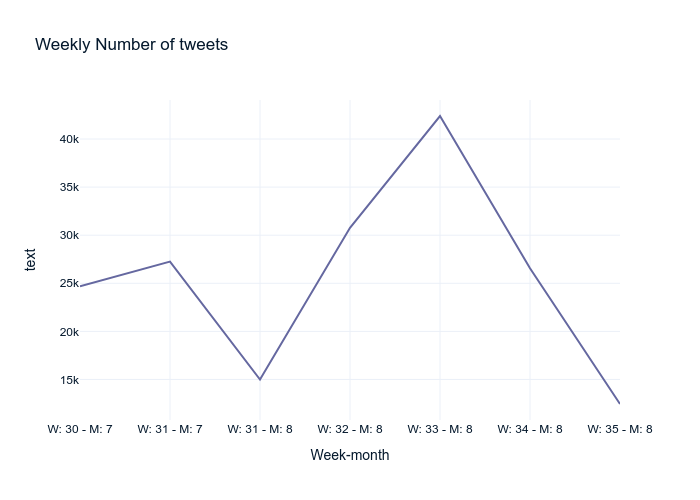

In [12]:
import plotly.express as px
import pandas as pd

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Extract week number
df['week_number'] = df['date'].dt.isocalendar().week

# Extract month
df['month'] = df['date'].dt.month

# Concat week + month
df['Week-month'] = 'W: ' + df['week_number'].astype(str) + ' - ' + 'M: ' + df['month'].astype(str)

# Group by week and calculate the count of text
df_grouped = df.groupby(['Week-month'])['text'].count().reset_index()
print(df_grouped.shape)

# Create a timeseries plot using Plotly
fig = px.line(df_grouped, x='Week-month', y='text', title='Weekly Number of tweets')

# Show the plot
# fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

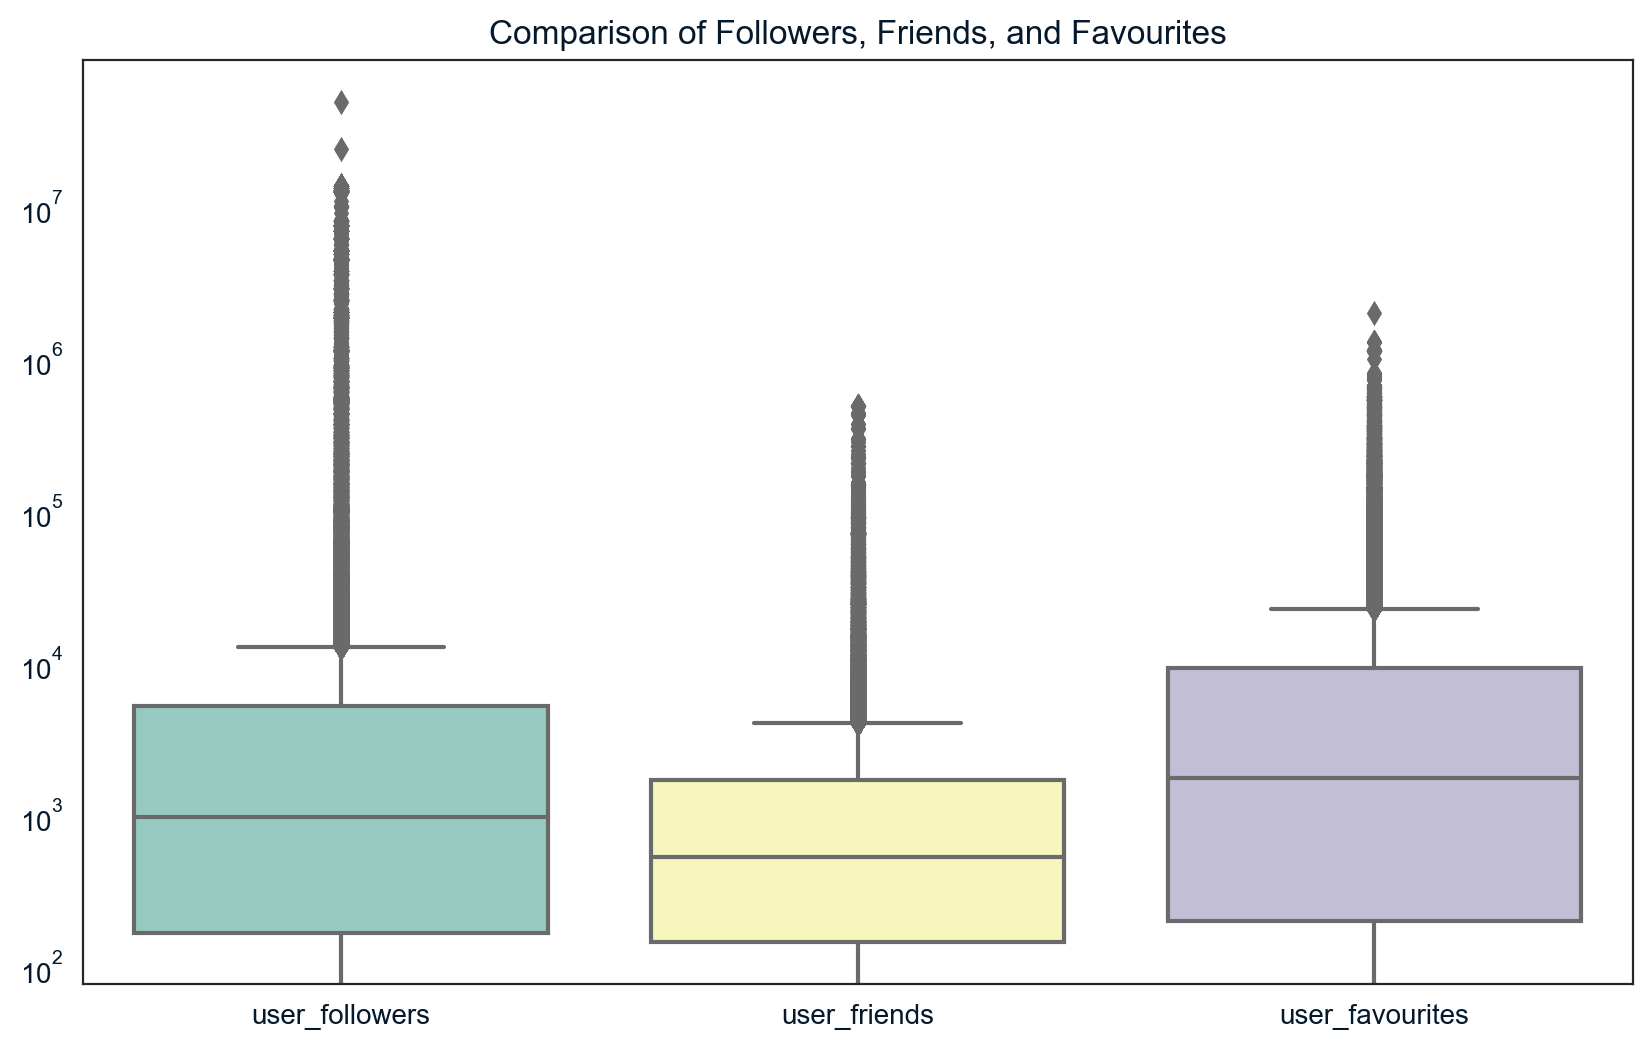

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots without grid lines
sns.set_style("white")

# Boxplot to compare followers, friends, and favourites
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['user_followers', 'user_friends', 'user_favourites']], palette="Set3")
plt.yscale('log')  # Using a log scale due to wide range of values
plt.title('Comparison of Followers, Friends, and Favourites')
plt.show()

In [16]:
print(f'Total tweets: {df.text.count()} \nUnique tweets: {df.text.nunique()}')

Total tweets: 179108 
Unique tweets: 178683


### WordCloud and most Frequent Words

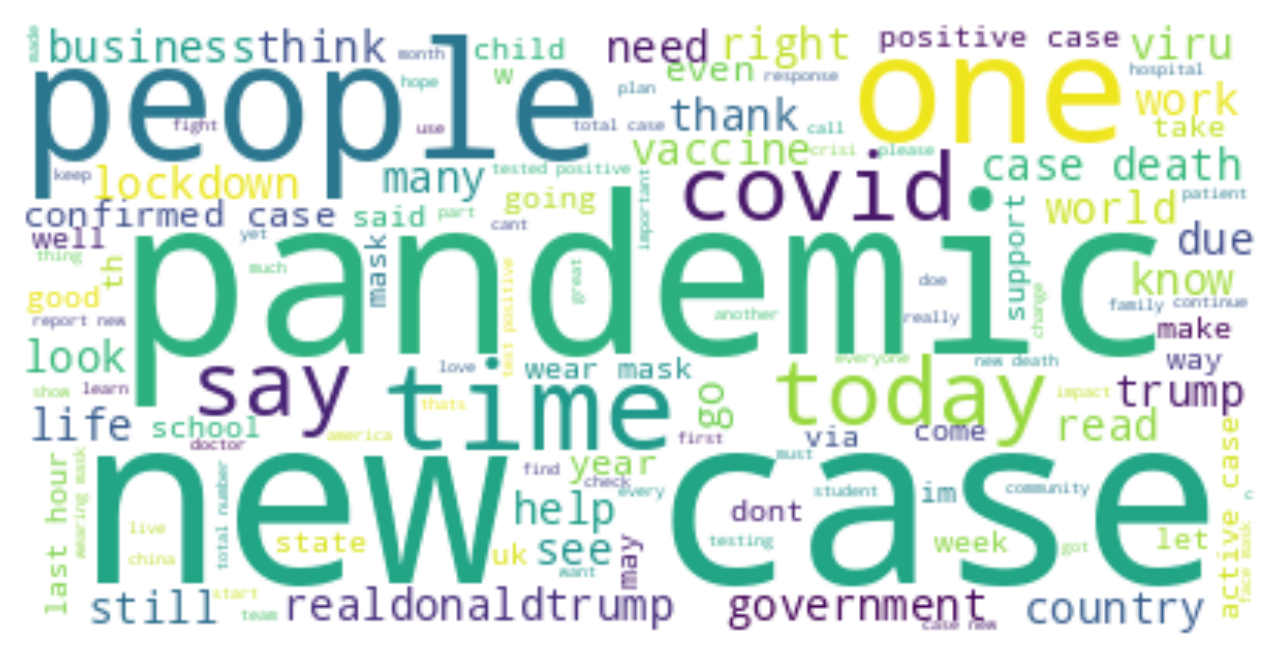

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the texts in the 'filtered_text' column into a single string
df['filtered_text_str'] = df['filtered_text'].apply(lambda x:' '.join(x))
text = ' '.join(df['filtered_text_str'])  # Join the text column into a single string

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

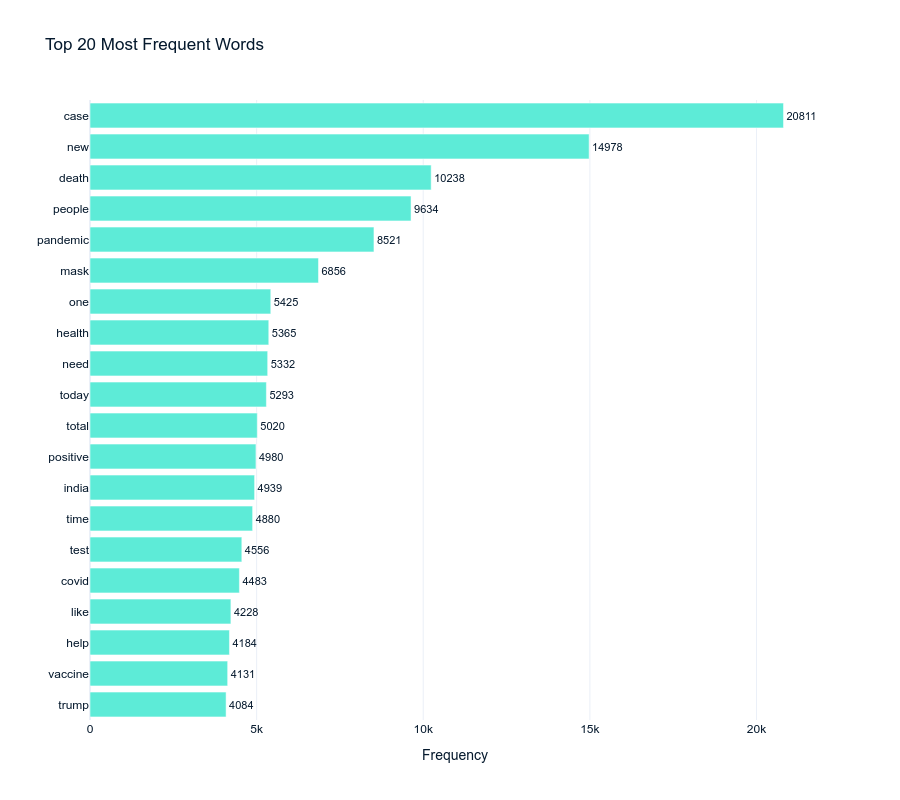

In [13]:
## -------------------------------------------- PARAMETERS --------------------------------------------
# Choose the number of words to show
n = 20

## -------------------------------------------- PREPARE DATA --------------------------------------------
# Count the frequency of tokens in the 'lemmatized_text' column
words = [word for words in df['filtered_text'] for word in words]
token_counts = Counter(words)

# Get the most common tokens (e.g., top 10) in reverse order
most_common_tokens = token_counts.most_common(n)[::-1]

# Split the tokens and their counts for plotting
tokens, counts = zip(*most_common_tokens)

## -------------------------------------------- VISUALIZE --------------------------------------------

# Create a horizontal bar chart using Plotly
fig = px.bar(x=counts, y=tokens, text=counts,
             labels={'x': 'Frequency', 'y': ''}, title=f'Top {n} Most Frequent Words')

# Customize the layout
fig.update_xaxes(title_text='Frequency')
fig.update_yaxes(categoryorder='total ascending')  # Sort the bars by frequency
fig.update_layout(showlegend=False)  # Hide the legend

# Set the figure size (width and height)
fig.update_layout(width=900, height=800)

# Set the background color to white
fig.update_layout(plot_bgcolor='white')

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                  textfont=dict(size=11)) # Rotate labels to 0°
#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

### n-grams

A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words.

In [15]:
def create_ngrams(words, n):
    list(words)
    ngrams = []
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i + n])
        ngrams.append(ngram)
    return ngrams

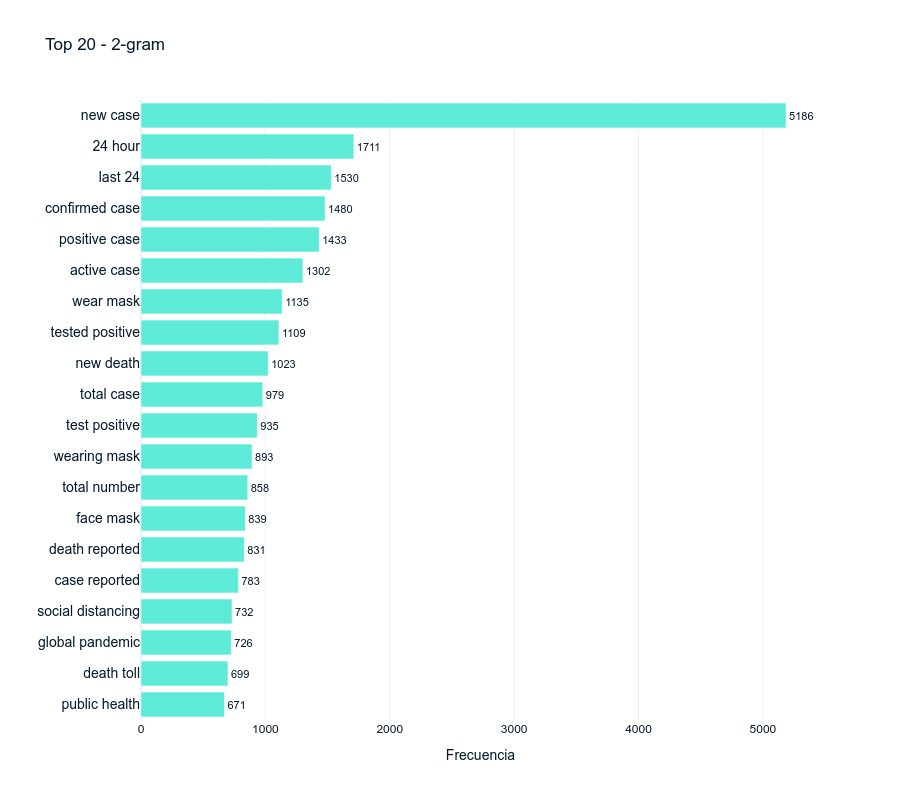

In [16]:
## -------------------------------------------- PARAMETERS --------------------------------------------
# n-grama size
n = 2
# Number of results to show
display = 20

## -------------------------------------------- PREPARE DATA --------------------------------------------

# n-gram creation
n_gram = create_ngrams(words ,n)

# Frerquency
n_counter = Counter(n_gram).most_common(display)[::-1]

# Split tokens and quantity
tokens, counts = zip(*n_counter)

## -------------------------------------------- VISUALIZE --------------------------------------------
fig = px.bar(y=tokens, x=counts, text=counts, labels={'x': 'Frecuencia', 'y': ''}, title=f'Top {display} - {n}-gram')
fig.update_xaxes(tickangle=0)

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                  textfont=dict(size=11)) # Rotate labels to 0°

# Set the figure size (width and height)
fig.update_layout(
       plot_bgcolor='white', width=900, height=800,
       yaxis_tickfont=dict(size=14))

#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

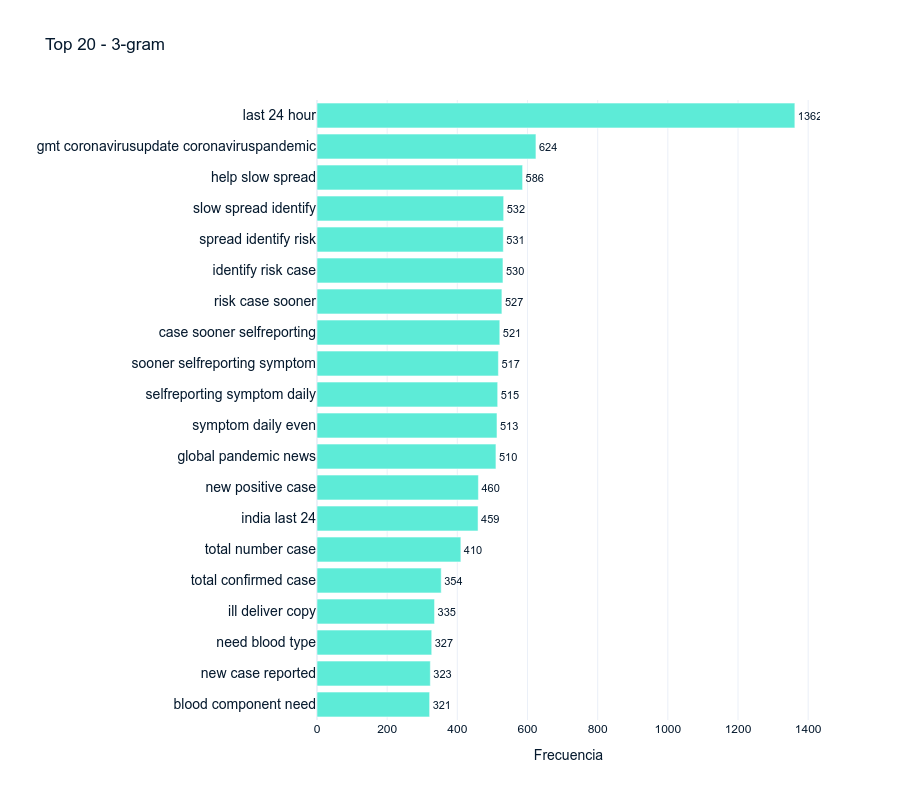

In [17]:
## -------------------------------------------- PARAMETERS --------------------------------------------
# n-grama size
n = 3
# Number of results to show
display = 20

## -------------------------------------------- PREPARE DATA --------------------------------------------

# n-gram creation
n_gram = create_ngrams(words ,n)

# Frerquency
n_counter = Counter(n_gram).most_common(display)[::-1]

# Split tokens and quantity
tokens, counts = zip(*n_counter)

## -------------------------------------------- VISUALIZE --------------------------------------------
fig = px.bar(y=tokens, x=counts, text=counts, labels={'x': 'Frecuencia', 'y': ''}, title=f'Top {display} - {n}-gram')
fig.update_xaxes(tickangle=0)

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                  textfont=dict(size=11)) # Rotate labels to 0°
                  
fig.update_layout(
       plot_bgcolor='white', width=900, height=800,
       yaxis_tickfont=dict(size=14))

#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

### Mentioned Accounts

In [19]:
def extract_accounts(tweet):
    return re.findall(r'@(\w+)', tweet)

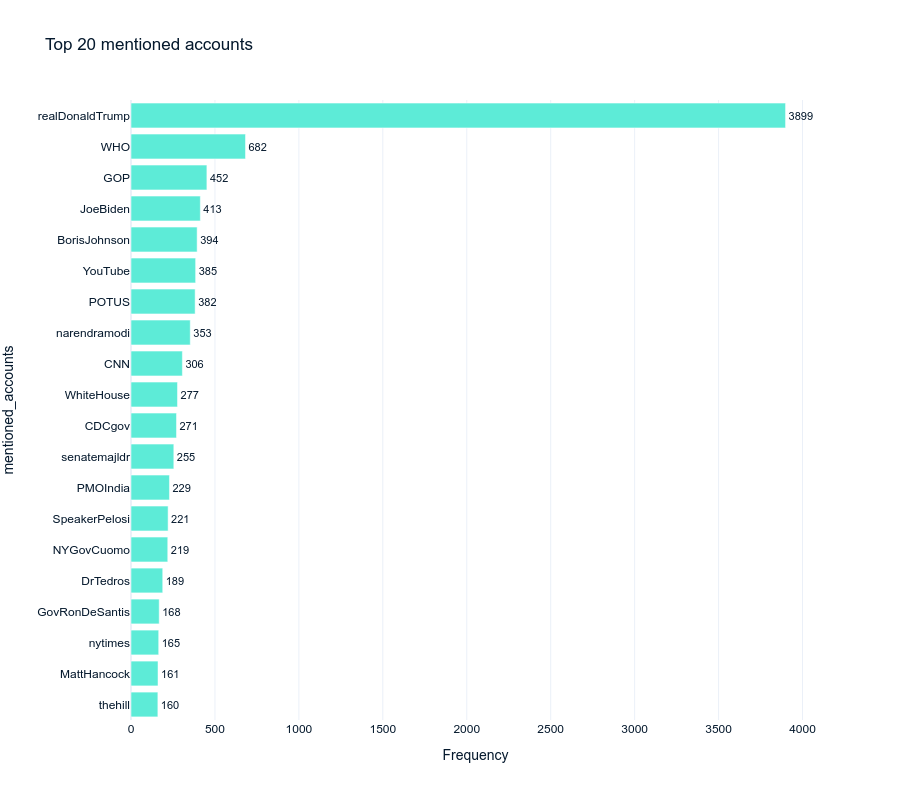

In [20]:
## -------------------------------------------- PARAMETERS --------------------------------------------
# Top n to display
n = 20

## -------------------------------------------- PREPARE DATA ------------------------------------------
df['mentioned_accounts'] = df['text'].apply(extract_accounts)
df_accounts = df.explode('mentioned_accounts')


## -------------------------------------------- VISUALIZE --------------------------------------------
# Create a horizontal bar chart using Plotly
fig = px.bar(df_accounts['mentioned_accounts'].value_counts().reset_index().head(n),x='count', y='mentioned_accounts', text='count',
             labels={'x': 'Frequency', 'y': ''}, title=f'Top {n} mentioned accounts ')

# Customize the layout
fig.update_xaxes(title_text='Frequency')
fig.update_yaxes(categoryorder='total ascending')  # Sort the bars by frequency
fig.update_layout(showlegend=False)  # Hide the legend

# Set the figure size (width and height)
fig.update_layout(width=900, height=800)

# Set the background color to white
fig.update_layout(plot_bgcolor='white')

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                  textfont=dict(size=11)) # Rotate labels to 0°              

#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

### Hashtags

In [21]:
def extract_hashtags(tweet):
    return re.findall(r'#(\w+)', tweet)

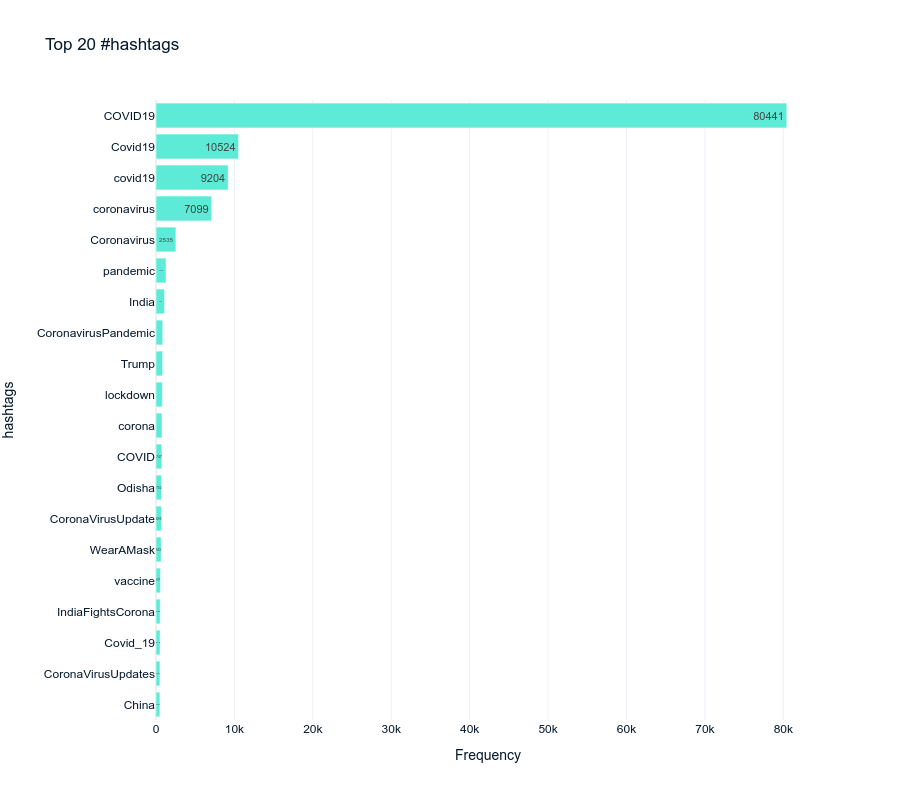

In [22]:
## -------------------------------------------- PARAMETERS --------------------------------------------
# Top n to display
n = 20

## -------------------------------------------- PREPARE DATA ------------------------------------------
df['hashtags'] = df['text'].apply(extract_hashtags)
df_hashtags = df.explode('hashtags')


## -------------------------------------------- VISUALIZE --------------------------------------------
# Create a horizontal bar chart using Plotly
fig = px.bar(df_hashtags['hashtags'].value_counts().reset_index().head(n),x='count', y='hashtags', text='count',
             labels={'x': 'Frequency', 'y': ''}, title=f'Top {n} #hashtags ')

# Customize the layout
fig.update_xaxes(title_text='Frequency')
fig.update_yaxes(categoryorder='total ascending')  # Sort the bars by frequency
fig.update_layout(showlegend=False)  # Hide the legend

# Set the figure size (width and height)
fig.update_layout(width=900, height=800)

# Set the background color to white
fig.update_layout(plot_bgcolor='white')

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                  textfont=dict(size=11)) # Rotate labels to 0°

# Show the Plotly chart with data labels and a custom figure size
fig.update_traces(texttemplate='%{text}', textposition='inside', textangle=0)  # Rotate labels to 0°

#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

## 04. Topic Modeling (LDA)

Latent Dirichlet Allocation (LDA) is a generative probabilistic model of a corpus. The basic idea is that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words. In LDA, each document is viewed as a mixture of topics, and each topic is a mixture of words. This allows LDA to capture the underlying themes or topics in a corpus of text data.

In this exercise, we will use Gensim, a popular Python library for topic modeling and document similarity analysis. Gensim provides an efficient and scalable implementation of LDA, allowing us to analyze large volumes of text data and extract meaningful insights from it. With Gensim, we can preprocess our text data, create a topic model, and extract topics and keywords from our corpus.

Here's a brief overview of the steps we'll take:

1. Data Preprocessing: We'll preprocess our text data by tokenizing the text, removing stop words, and converting all words to lowercase.
2. Creating a Gensim Dictionary: We'll create a Gensim dictionary from our preprocessed data, which will map each word to a unique integer ID.
3. Creating a Gensim Corpus: We'll create a Gensim corpus from our preprocessed data, which will represent each document as a bag-of-words.
4. Training an LDA Model: We'll train an LDA model using our Gensim corpus and dictionary, specifying the number of topics and other hyperparameters.
5. Extracting Topics and Keywords: We'll extract the topics and keywords from our trained LDA model, and visualize the results using various visualization tools.

By the end of this exercise, we'll have a working LDA model that can extract meaningful topics and keywords from our text data.

### Prepare the Data

In [26]:
from gensim import corpora

# Convert documents into list
documents = df['filtered_text'].tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(documents) #id2word
corpus = [dictionary.doc2bow(doc) for doc in documents]

### Find the Optimal Number of Topics

In [27]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

def find_optimal_num_topics(corpus, id2word, texts, start=2, limit=40, step=2):
    """
    Find the optimal number of topics.

    Parameters:
    - corpus: corpus object
    - id2word: Gensim dictionary object, 
    - texts: List of tokenized documents
    - start: Initial number of topics to consider
    - limit: Maximum number of topics to consider
    - step: Step size for iterating through number of topics

    Returns:
    - A list of tuples containing (number of topics, coherence score)
    """
    coherence_scores = []
    
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, chunksize=1500,         alpha=0.5, passes=150, gamma_threshold = 0.3)
        
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        
        coherence_scores.append((num_topics, coherence_score))

    return coherence_scores


In [111]:
optimal_num_topics = find_optimal_num_topics(corpus, dictionary, documents, start=2, limit=10, step=1)
print(optimal_num_topics)

KeyboardInterrupt: 

In [112]:
max_cv = max(optimal_num_topics, key=lambda item: item[1])
print(f"The optimal number of topics is:",max_cv[0])

The optimal number of topics is: 2


**LDA Hyperparameters in Gensim**

The LdaModel class in Gensim's gensim.models module offers several hyperparameters that influence the training and behavior of your Latent Dirichlet Allocation (LDA) model. Tuning these parameters is crucial for obtaining optimal results on your specific dataset and task. Let's explore some key hyperparameters:

Corpus-related:
- corpus: This is the input corpus represented as a list of lists, where each inner list contains the tokens of a document.
- id2word: A mapping between word IDs and words, typically created using gensim.corpora.Dictionary.

Model parameters:
- num_topics: (int, required) The number of topics to be discovered in the corpus. Choosing the right number is crucial and often                   involves experimentation and evaluation.
- alpha: (float, optional) Controls the document-topic density. Higher values mean documents are more likely to contain a mixture of            topics.
    Default: 'symmetric' (all topics are treated equally)
    Can be set to 'asymmetric' for automatic optimization, or a specific value between 0.01 and 1.
- eta: (float, optional) Controls the topic-word density. Higher values mean topics are more likely to contain a mixture of words.
    Default: 'symmetric' (all words are treated equally within a topic)
    Can be set to 'auto' for automatic optimization, or a specific value between 0.01 and 1.
- decay: (float, optional) Controls how quickly the learning rate decreases during training. A higher value means the learning rate             decays faster.
    Default: 0.5
- offset: (float, optional) A constant added to the learning rate to prevent it from becoming too small.
    Default: 1.0
    
Training parameters:
- chunksize: (int, optional) Number of documents to be used in each training chunk.
    Default: 100
- passes: (int, optional) Number of passes through the corpus during training.
    Default: 1
update_every: (int, optional) Number of documents to be processed before updating the model.
    Default: 1
eval_every: (int, optional) Number of documents to be processed before evaluating the model perplexity.
    Default: None
Other parameters:
- random_state: (int, optional) Seed for the random number generator to ensure reproducibility.
- minimum_probability: (float, optional) Topics with a probability below this threshold will be filtered out.
    Default: 0.01
minimum_phi_value: (float, optional) Words with a probability below this threshold will be filtered out from the topic-word distribution.
    Default: 0.01

### Run LDA

In [113]:
from gensim.models import LdaModel
#from gensim.models import CoherenceModel

# Type the number of topics to model
num_topics = max_cv[0]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics = num_topics , id2word=dictionary, passes=120, chunksize=5000, alpha='auto', gamma_threshold = 0.3, random_state = 12 )

# Calculate Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
print(f'Coherence Score: {coherence_model_lda.get_coherence()}')

Coherence Score: 0.46800684841556933


### Results


In [114]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Assuming you have your LDA model and corpus
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [115]:
import builtins

# Function to categorize comments in each topic according to maximum probability
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_distribution = lda_model.get_document_topics(doc)
        dominant_topic = builtins.max(topic_distribution, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics


In [116]:
# Apply get_dominant_topic function
df["topic_label"] = get_dominant_topic(lda_model, corpus)

In [117]:
# --------------------------------------------- GRAFICAR --------------------------------------------
fig = px.pie(df, names=df.topic_label.value_counts().index, values=df.topic_label.value_counts().values, hole=0.5)
fig.update_traces(textinfo='percent+label', pull=[0, 0, 0, 0], textposition='inside')
fig.update_layout(title='Distribution of tweets per dominant topic')

#fig.show()

# Save the figure as an image
fig.write_image("temp_figure.png")

# Display the image
Image("temp_figure.png")

In [118]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,text_clean,tokenized_text,lemmatized_text,filtered_text,week_number,month,Week-month,filtered_text_str,mentioned_accounts,topic_label
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,[],Twitter for iPhone,False,if i smelled the scent of hand sanitizers toda...,"[if, i, smelled, the, scent, of, hand, sanitiz...","[if, i, smelled, the, scent, of, hand, sanitiz...","[smelled, scent, hand, sanitizers, today, some...",30,7,W: 30 - M: 7,smelled scent hand sanitizers today someone pa...,[],0
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,[],Twitter for Android,False,hey yankees yankeespr and mlb wouldnt it have...,"[hey, yankees, yankeespr, and, mlb, wouldnt, i...","[hey, yankee, yankeespr, and, mlb, wouldnt, it...","[hey, yankee, yankeespr, mlb, wouldnt, made, s...",30,7,W: 30 - M: 7,hey yankee yankeespr mlb wouldnt made sense pl...,"[Yankees, YankeesPR, MLB]",0
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,[COVID19],Twitter for Android,False,diane3443 wdunlap realdonaldtrump trump never ...,"[diane3443, wdunlap, realdonaldtrump, trump, n...","[diane3443, wdunlap, realdonaldtrump, trump, n...","[diane3443, wdunlap, realdonaldtrump, trump, n...",30,7,W: 30 - M: 7,diane3443 wdunlap realdonaldtrump trump never ...,"[diane3443, wdunlap, realDonaldTrump]",0
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,[COVID19],Twitter for iPhone,False,brookbanktv the one gift covid19 has give me i...,"[brookbanktv, the, one, gift, covid19, has, gi...","[brookbanktv, the, one, gift, covid19, ha, giv...","[brookbanktv, one, gift, give, appreciation, s...",30,7,W: 30 - M: 7,brookbanktv one gift give appreciation simple ...,[brookbanktv],0
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"[CoronaVirusUpdates, COVID19]",Twitter for Android,False,25 july media bulletin on novel coronavirusup...,"[25, july, media, bulletin, on, novel, coronav...","[25, july, medium, bulletin, on, novel, corona...","[25, july, medium, bulletin, novel, coronaviru...",30,7,W: 30 - M: 7,25 july medium bulletin novel coronavirusupdat...,"[kansalrohit69, DrSyedSehrish, airnewsalerts, ...",1


Relevant words by Topic

Finally, we will use TF-IDF (Term Frequency-Inverse Document Frequency) to identify the most relevant words in each topic. TF-IDF is a statistical measure that evaluates the importance of a word within a document and across the entire corpus. It takes into account not only the frequency of the word in a document (Term Frequency), but also its rarity across the entire corpus (Inverse Document Frequency). This allows us to identify words that are both frequent in a document and distinctive across the corpus, making them more likely to be relevant and meaningful in each topic.

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

for topic in sorted(df.topic_label.unique()):
    
    
    ## -------------------------------------------- PARAMETERS --------------------------------------------
    # Top n to display
    n=15
    
    ## -------------------------------------------- PREPARE DATA -------------------------------------------
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=n)
    
    # Filter dataset by topic
    data_topic = df[df.topic_label == topic]

    # Transform array into text
    data_topic['Content_text'] = data_topic['filtered_text'].apply(lambda x: ' '.join(x))

    # Adjust the vectorizer to the data
    tfidf_matrix = vectorizer.fit_transform(data_topic['Content_text'])

    # Extract names and sum of scores
    feature_names = vectorizer.get_feature_names_out()
    word_scores = tfidf_matrix.sum(axis=0).A1

    # Organize values, order and split
    word_scores_dict = dict(zip(feature_names, word_scores))
    sorted_words = sorted(word_scores_dict.items(), key=lambda x: x[1], reverse=False)
    top_words, top_scores  = zip(*sorted_words)


    ## -------------------------------------------- VISUALIZE --------------------------------------------
    fig = px.bar(y=top_words, x=top_scores, text=np.round(top_scores,1))
    fig.update_layout(
        title=f"Topic {topic} - {n} most relevant words (Sum of TF-IDF Score)",
        xaxis_title="Word",
        yaxis_title="TF-IDF Score",
        plot_bgcolor='white', 
        width=1000, height=700,
        yaxis_tickfont=dict(size=14)
    )
    fig.update_xaxes(tickangle=45) 
    fig.update_traces(textposition='outside',textangle=0, marker=dict(color='#5DEBD7'),
                      textfont=dict(size=13))
    #fig.show()
    # Save the figure as an image
    fig.write_image("temp_figure.png")

    # Display the image
    Image("temp_figure.png")